This will use the mushroom dataset: https://www.kaggle.com/datasets/uciml/mushroom-classification . Which comprises of 8000+ types of mushroom classified as poisonous or edible.

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [9]:
data_file = pd.read_csv("mushrooms.csv")

In [10]:
data_file.head(5)
data_file.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

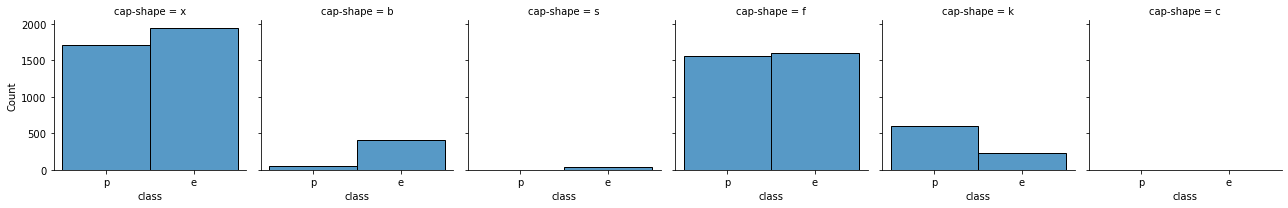

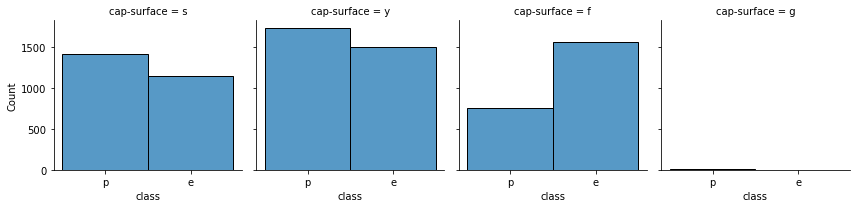

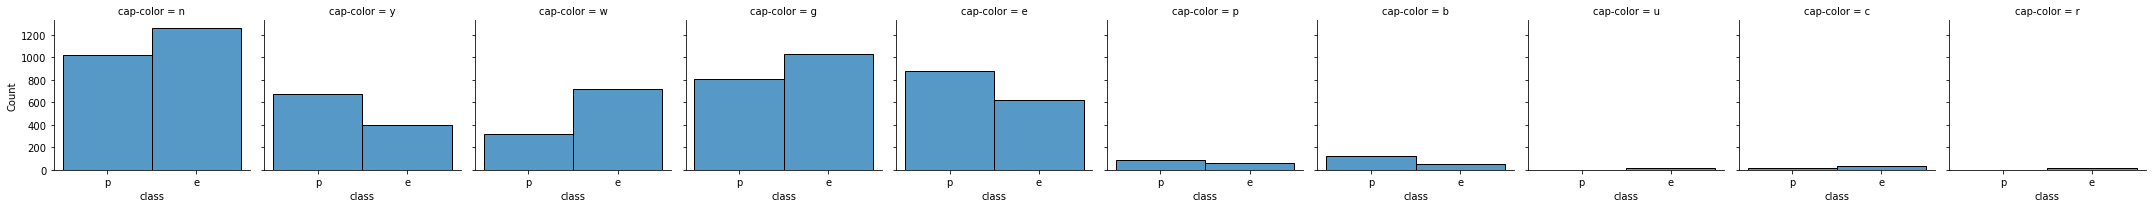

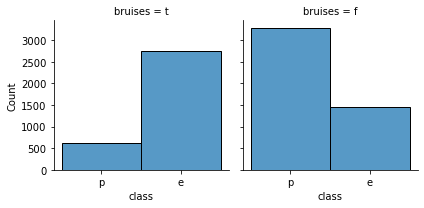

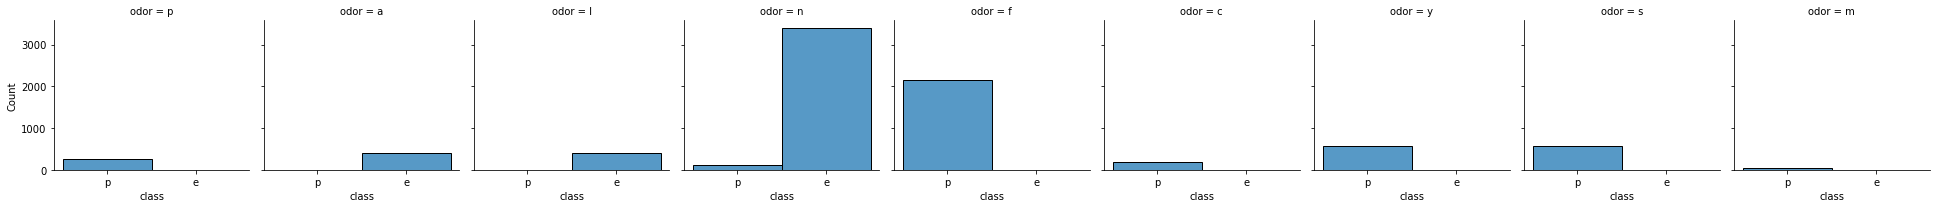

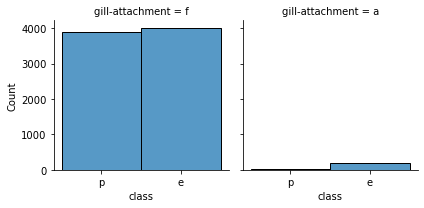

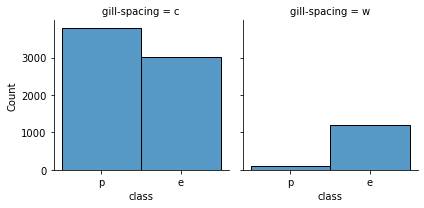

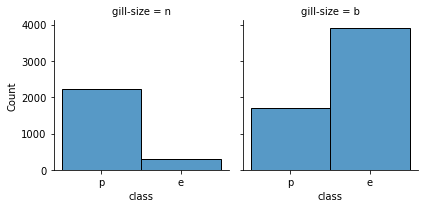

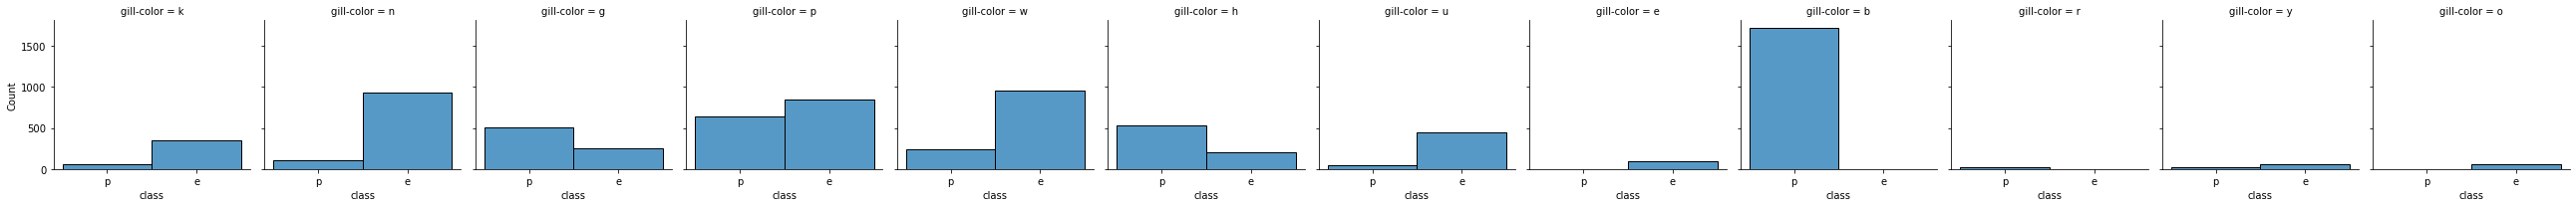

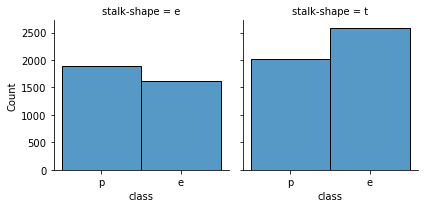

In [11]:
for col in data_file.columns[1:11]:
    graph = sns.FacetGrid(data_file, col=col)
    graph.map(sns.histplot, "class")
    plt.show()
    


First and foremost we will clean the data for missing and Null values. In this data set only one one attribute, stalk-root, has a possible value of missing. If a minority of those values are missing, we can consider dropping those entries, if more we should consider dropping the collumn 

In [12]:
data_file.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

This just shows there are no null values

In [13]:

data_file["stalk-root"].value_counts()["?"]/len(data_file)

0.3052683407188577

The attribute is missing 30% of the values , which suggests that that collumn could be dropped but, for now, let us consider it as a individual label. Then let us encode the classes. One hot encoding for attributes with two or more possible values, 0 and 1 for binary ones.

In [14]:
from sklearn.preprocessing import LabelEncoder
binary_columns = ["class","bruises","gill-size","stalk-shape","veil-type"]
for col in binary_columns:
    data_file[col] = LabelEncoder().fit_transform(data_file[col])
data_file.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,f,c,1,k,...,s,w,w,0,w,o,p,k,s,u
1,0,x,s,y,1,a,f,c,0,k,...,s,w,w,0,w,o,p,n,n,g
2,0,b,s,w,1,l,f,c,0,n,...,s,w,w,0,w,o,p,n,n,m
3,1,x,y,w,1,p,f,c,1,n,...,s,w,w,0,w,o,p,k,s,u
4,0,x,s,g,0,n,f,w,0,k,...,s,w,w,0,w,o,e,n,a,g


In [15]:
non_binary_cols = [ 'cap-shape', 'cap-surface', 'cap-color', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-color',
        'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']
data = pd.get_dummies(data_file, columns = non_binary_cols)
data.head(5)

,class,bruises,gill-size,stalk-shape,veil-type,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
x,y = data.iloc[:,1:], data.iloc[:,0]
y.head(5)

0    1
1    0
2    0
3    1
4    0
Name: class, dtype: int32

Feature engineering
We use the chi squared, in this metric to exclude the null hypothesis we generally want the p_value to be less than 0.05

In [17]:
from sklearn.feature_selection import chi2
_,p_value = chi2(x, y)
condition = np.where(np.array(p_value)<0.05)
print(len(condition[0]))

108


This would mean that 108 of the 115 features are probably impactful enough. However using all the features would incur substantial computational costs. So only the top 20 features will be used. Then a 60/40 train/test split will be done for fitting our model, generally the split is 70/30 for training/test accuracy but some of the test set will be used to for a validation set on the next algorithm.

In [18]:
from sklearn.feature_selection import SelectKBest
bestfeatures = SelectKBest(score_func=chi2, k=20)
filtered_x = bestfeatures.fit_transform(x,y)

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(filtered_x, y.to_numpy(), test_size = 0.4, random_state = 0)

Now we start the clasification. In this script we will try a simple ANN and the random forests method

In [32]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(x_train,y_train)

RandomForestClassifier(max_depth=5)

it has an accuracy of:98.95 %


<AxesSubplot:>

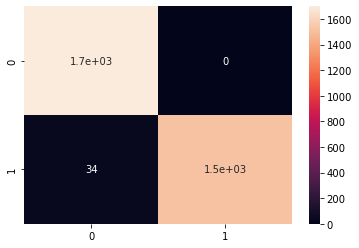

In [33]:

from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
print("it has an accuracy of:{:.2f} %".format(accuracy_score(y_test, y_pred)*100))
sns.heatmap(cf_matrix, annot= True)

Now let us try with an ANN for this we will use pytorch lightning. First we will use a validation,test split, the former will provide us an stop criterion, so we will stop the training once the validation accuracy reaches its max value, the later will be the unseen data to test its performance

In [34]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5)

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.functional import accuracy as accuracy_function
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

train_data = torch.Tensor(x_train),torch.Tensor(y_train).reshape(-1,1)
test_data =torch.Tensor(x_test),torch.Tensor(y_test).reshape(-1,1)
valid_data =torch.Tensor(x_valid),torch.Tensor(y_valid).reshape(-1,1)

train_dataset = TensorDataset(train_data[0],train_data[1]) 
test_dataset = TensorDataset(train_data[0],train_data[1])
valid_dataset = TensorDataset(valid_data[0],valid_data[1])
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size,num_workers=4)
test_loader = DataLoader(test_dataset,batch_size=batch_size*2,num_workers=4)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size*2,num_workers=4)

In [36]:
class MushroomClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(20, 64),nn.BatchNorm1d(64),nn.ReLU(), nn.Linear(64, 64),nn.BatchNorm1d(64)
                                   ,nn.ReLU(),nn.Linear(64, 1),nn.Sigmoid())
        self.loss_function = nn.BCELoss()

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_function(y_hat, y)
        accuracy = accuracy_function(y_hat,target=y.type(torch.int))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        if len(y) == 1:
            y = y.reshape(-1,1) #lightning bug
        y_hat = self.model(x)
        loss = self.loss_function(y_hat,y)
        accuracy = accuracy_function(y_hat,target=y.type(torch.int))
        self.log("val_accuracy", accuracy, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_function(y_hat,y)
        accuracy = accuracy_function(y_hat,target=y.type(torch.int))
        self.log("test_accuracy", accuracy, prog_bar=True)
        return loss
    def validation_epoch_end(self, outs):
        # outs is a list of whatever you returned in `validation_step`
        loss = torch.stack(outs).mean()
        self.log("val_loss", loss, prog_bar=True)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [39]:
trainer = pl.Trainer(callbacks=[EarlyStopping(monitor="val_accuracy", mode="max")],max_epochs=100)
model = MushroomClassifier()
data = next(iter(valid_loader))

trainer.fit(model, train_loader,valid_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 5.8 K 
1 | loss_function | BCELoss    | 0     
---------------------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [41]:
trainer.test(dataloaders=test_loader,ckpt_path='best')

Restoring states from the checkpoint path at C:\Users\ASUS\notebooks\lightning_logs\version_12\checkpoints\epoch=4-step=765.ckpt
Loaded model weights from checkpoint at C:\Users\ASUS\notebooks\lightning_logs\version_12\checkpoints\epoch=4-step=765.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 1.0}]

This gives a test accuracy of 100%. 